In this notebook, we introduce two novel layers tailored for convolutional neural networks (CNNs): the SplitLinear layers and DropNorm layer. These additions aim to enhance model performance and flexibility by offering specialized functionalities within the network architecture. Let's delve into their implementation and explore their potential benefits for various CNN applications.

# **Introducing the SplitLinear layer**

The SplitLinear class represents a custom PyTorch layer designed to process 2D tensors by splitting them along the feature dimension. Upon initialization, it creates a linear layer and an activation function (ReLU). During the forward pass, the input tensor is split into two halves along the feature dimension. Each split tensor then undergoes the same linear transformation using the shared linear layer. Subsequently, the ReLU activation function is applied to both transformed tensors independently. Finally, the resulting tensors are concatenated along the feature dimension to produce the output tensor. The linear layer parameters are initialized using random numbers in a specified range, determined by the number of input features. This approach enables efficient processing of high-dimensional data while promoting flexibility and expressive power in modeling complex relationships.

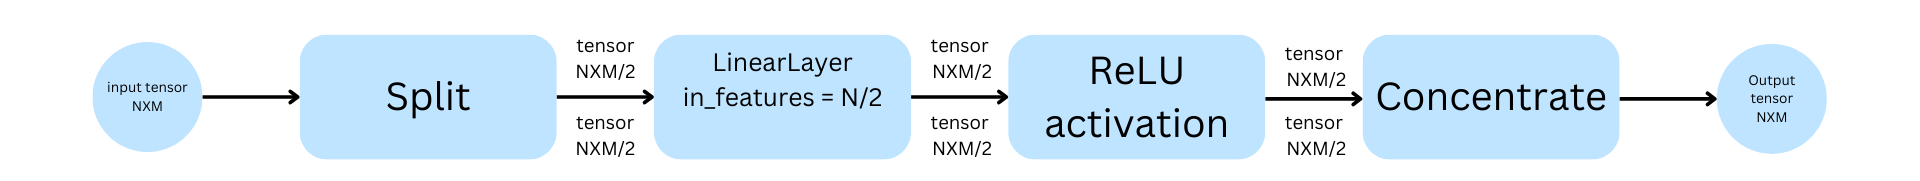

In [ ]:
import torch
import torch.nn as nn


In [ ]:
# Set device to calculate on
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
class SplitLinear:
    """
    A custom PyTorch layer designed to process 2D tensors by splitting them along the feature dimension,
    passing each split through a shared linear layer followed by a ReLU activation function, and then
    recombining the results.

    Args:
        in_features (int): Number of input features.

    Attributes:
        in_features (int): Number of input features.
        linear_layer (torch.nn.Linear): Linear layer for processing split tensors.
        activation_layer (torch.nn.ReLU): ReLU activation function.

    Methods:
        forward(tensor_in): Performs a forward pass through the SplitLinear layer.
        split_tensor(tensor_in): Splits the input tensor into two tensors along the feature dimension.
        generate_uniform_numbers_in_range(k, size): Generates uniform random numbers in a specified range.

    """

    def __init__(self, in_features):
        """
        Initializes the SplitLinear layer with the specified number of input features.

        Args:
            in_features (int): Number of input features.

        """
        self.in_features = in_features
        self.linear_layer = nn.Linear(in_features // 2, in_features // 2)
        self.__init_params()
        self.activation_layer = nn.ReLU()

    def forward(self, tensor_in):
        """
        Performs a forward pass through the SplitLinear layer.

        Args:
            tensor_in (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the SplitLinear layer.

        """
        print("Original tensor:", tensor_in, sep="\n", end="\n\n")

        left, right = self.split_tensor(tensor_in)
        print("The original tensor was divided into two new tensors:", left, right, sep="\n", end="\n\n")

        left = self.linear_layer(left)
        right = self.linear_layer(right)
        print("The new tensors passed through the same linear layer:", left, right, sep="\n", end="\n\n")

        left = self.activation_layer(left)
        right = self.activation_layer(right)
        print("Ultimately, the tensors underwent the ReLU activation:", left, right, sep="\n", end="\n\n")

        res = torch.cat([left, right], dim=1)
        print("Combining the two resultant tensors yields:\n", res, end="\n\n")

        return res


    @staticmethod
    def split_tensor(tensor_in):
        """
        Splits the input tensor into two tensors along the feature dimension.

        Args:
            tensor_in (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Left split tensor.
            torch.Tensor: Right split tensor.

        """
        split_idx = tensor_in.size()[1] // 2
        left = tensor_in[:, :split_idx]
        right = tensor_in[:, split_idx:]
        return left, right

    @staticmethod
    def generate_uniform_numbers_in_range(k, size):
        """
        Generates uniform random numbers in the range [-k, k].

        Args:
            k (float): Scaling factor for the range.
            size (tuple): Size of the tensor to be generated.

        Returns:
            torch.Tensor: Tensor of uniform random numbers in the range [-k, k].

        """
        uniform_numbers = torch.rand(size)
        scaled_numbers = 2 * k * (uniform_numbers - 0.5)
        return scaled_numbers

    def __init_params(self):
        """
        Initializes the parameters of the linear layer using random numbers in the range [-k_in^(-0.5), k_in^(-0.5)],
        where k_in is the number of inputs of the linear layer.

        """

        k = (0.5 * self.in_features) ** (-0.5)  # linear_layer_in_features^-0.5
        linear_layer_size = self.in_features // 2
        size = (linear_layer_size, linear_layer_size + 1)  # +1 for bias
        uniform_numbers_in_range = self.generate_uniform_numbers_in_range(k, size)

        with torch.no_grad():
            weight_init = uniform_numbers_in_range[:, :-1]
            bias_init = uniform_numbers_in_range[:, -1]
            self.linear_layer.weight = nn.Parameter(weight_init)
            self.linear_layer.bias = nn.Parameter(bias_init)


I initialized the layer parameters similarly to how torch.nn.Linear initializes its parameters

Let's delve into the operations of the SplitLinear layer by creating an instance of the class and examining its behavior on a sample tensor

In [ ]:
layer = SplitLinear(6)
C = torch.arange(30,dtype=torch.float32).reshape(5,6)


In [ ]:
layer.forward(C);

Original tensor:
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.],
        [12., 13., 14., 15., 16., 17.],
        [18., 19., 20., 21., 22., 23.],
        [24., 25., 26., 27., 28., 29.]])

The original tensor was divided into two new tensors:
tensor([[ 0.,  1.,  2.],
        [ 6.,  7.,  8.],
        [12., 13., 14.],
        [18., 19., 20.],
        [24., 25., 26.]])
tensor([[ 3.,  4.,  5.],
        [ 9., 10., 11.],
        [15., 16., 17.],
        [21., 22., 23.],
        [27., 28., 29.]])

The new tensors passed through the same linear layer:
tensor([[-0.5322, -0.5938,  1.1930],
        [-0.5857, -0.8823, 11.2780],
        [-0.6392, -1.1709, 21.3631],
        [-0.6927, -1.4594, 31.4482],
        [-0.7461, -1.7479, 41.5332]], grad_fn=<AddmmBackward0>)
tensor([[-0.5589, -0.7381,  6.2355],
        [-0.6124, -1.0266, 16.3206],
        [-0.6659, -1.3151, 26.4056],
        [-0.7194, -1.6036, 36.4907],
        [-0.7729, -1.8922, 46.5757]], grad_fn=<AddmmBackward

# **Layer Analysis**

## Number of parameters

In a standard linear layer operating on a tensor of size N x M, the parameters of the linear layer can be expressed as $N_1 = M \cdot M + M  = M^2 + M$.

However, in our linear layer, the input dimensions for the linear layer are halved, resulting in M/2. Consequently, the number of parameters for the linear layer within the SplitLinear layer becomes $N_2 = \frac{M}{2} ⋅ \frac{M}{2} + \frac{M}{2} = \frac{M^2}{4} + \frac{M}{2}$.

Thus, the ratio between this cases is: in parameters between our layer and the standarnumber of parameters between this cases: $\frac{N_1} {N_2} = \frac{M (M+1)}{\frac{M}{2}(\frac{M}{2}+1)}=2\frac{M+1}{\frac{M}{2}+1} = 2(\frac{ \frac{M}{2}+1}{\frac{M}{2}+1}+\frac{\frac{M}{2}} {\frac{M}{2}+1})= 2(1+\frac{\frac{M}{2}}{\frac{M}{2}+1}) $, approaches 4 when M is large.
Therfore using the new layer helps with parameters reduction.

## Layer Parameter Gradient Analysis

We assume that the gradient of the loss function with respect to the outputs is given as $\frac{\partial{C}}{\partial{Y}}$. Our objective is to calculate the gradient of the loss function with respect to the layer parameters using the chain rule.

Let's denote the input tensor $X$, which is split into two parts, $X_1$ and $X_2$, along the feature dimension. These parts represent the input to the linear layer:
\begin{align}
  X = \begin{bmatrix}
          x_{0} \\
          x_{1} \\
          \vdots \\
          x_{m-1}
        \end{bmatrix}
    =
        \begin{bmatrix}
          X_{1} \\
          X_{2}
        \end{bmatrix} \in R^M
\end{align}

Next, we express the outputs of the linear layer as $Z_1$ and $Z_2$:

\begin{align}
  Z_1=WX_1 + b ,\hspace{0.5cm} Z_2=WX_2 + b
\end{align} \
 where $W \in R^{\frac{M}{2} \times \frac{M}{2}}$ and $b \in R^\frac{M}{2}$ are the weights and biases of the linear layer, respectively. Therefore, $Z_1$, $Z_2$ ∈ $R^\frac{M}{2}$. \
We also define $Z$ as the concatenation of $Z_1$ and $Z_2$, representing the total output of the linear layer.

\begin{align}
  Z = \begin{bmatrix}
          z_{0} \\
          z_{1} \\
          \vdots \\
          z_{m-1}
        \end{bmatrix}
    =
        \begin{bmatrix}
          Z_{1} \\
          Z_{2}
        \end{bmatrix} \in R^M
\end{align}


The results of the activation layer are given by $Y_1 = ReLU(Z_1)$ and $Y_2 = ReLU(Z_2)$, where $Y_1, Y_2 \in R^\frac{M}{2}$.

Thus, the total output of the layer is denoted as:
\begin{align}
  Y =
        \begin{bmatrix}
          y_0 \\
          y_1 \\
          \vdots \\
          y_{m-1}
        \end{bmatrix}
        =
        \begin{bmatrix}
          Y_{1} \\
          Y_{2}
        \end{bmatrix}
        \in R^M
\end{align}

Assuming that $\frac{\partial{C}}{\partial{Y}}$ is given as:
\begin{align}
  \frac{\partial{C}}{\partial{Y}} =  
  \begin{bmatrix}
    \frac{\partial{C}}{\partial{Y_1}}\\
    \frac{\partial{C}}{\partial{Y_2}}
  \end{bmatrix}
     =
  \begin{bmatrix}
    \frac{\partial{C}}{\partial{y_0}}\\
    \vdots \\
    \frac{\partial{C}}{\partial{y_{M-1}}}
  \end{bmatrix}
\end{align}

Our goal is to calculate the gradient of the cost function. Using the chain rule, we obtain:

\begin{align}
  \frac{\partial{C}}{\partial{W}} = \frac{\partial{C}}{\partial{Y}}  \frac{\partial{Y}}{\partial{Z}} \frac{\partial{Z}}{\partial{W}}  
\end{align}

\
For $k \in \{1,2\}$:
\begin{align*}
\frac{\partial{Z_{k,i}}}{\partial{W_{ij}}} &= \frac{\partial{z_{(k-1)⋅\frac{M}{2} + i}}}{\partial{W_{ij}}} = \frac{\partial{\sum_{n=0}^{\frac{M}{2}} W_{in} \cdot X_{k,n}}+b_n}{\partial{W_{ij}}} = x_{(k-1)⋅\frac{M}{2} + j} \\
\frac{\partial{Z_{k,i}}}{\partial{b_{i}}} &= \frac{\partial{z_{(k-1)⋅\frac{M}{2} + i}}}{\partial{b_{i}}} = \frac{\partial{\sum_{n=0}^{\frac{M}{2}} W_{in} \cdot X_{k,n}}+b_n}{\partial{b_{i}}} = 1 \\
\frac{\partial{Y_{k,i}}}{\partial{Z_{k,i}}} &= \frac{\partial{y_{(k-1)⋅\frac{M}{2} + i}}}{\partial{z_{(k-1)⋅\frac{M}{2} + i}}} = \frac{\partial{ReLU(z_{(k-1)⋅\frac{M}{2} + i})}}{\partial{z_{(k-1)⋅\frac{M}{2} + i}}} = 1\{z_{(k-1)⋅\frac{M}{2} + i} ≥ 0\}
\end{align*}

where:
\begin{align*}
X_{k,j} &= x_{(k-1)⋅\frac{M}{2} + j}
\end{align*}

\
Additionally:
\begin{align*}
\frac{\partial{Z_{k,l}}}{\partial{W_{ij}}} &= 0, \quad \frac{\partial{Z_{k,l}}}{\partial{b_{i}}} = 0 \quad \text{for} \quad l \neq i, \quad k \in \{1,2\}
\end{align*}

Therefore, we have:
\begin{align*}
\frac{\partial{Y_{k,l}}}{\partial{W_{ij}}} &= \frac{\partial{Y_{k,l}}}{\partial{Z_{k,l}}}\frac{\partial{Z_{k,l}}}{\partial{W_{ij}}} = 0 \quad \text{for} \quad l \neq i, \quad k \in \{1,2\} \\   
\frac{\partial{Y_{k,l}}}{\partial{b_{i}}} &= \frac{\partial{Y_{k,l}}}{\partial{Z_{k,l}}}\frac{\partial{Z_{k,l}}}{\partial{b_{i}}} = 0 \quad \text{for} \quad l \neq i, \quad k \in \{1,2\}
\end{align*}

Summing it all up:
\begin{align}
\frac{\partial{C}}{\partial{W_{ij}}} &= \frac{\partial{C(Y_1,Y_2)}}{\partial{W_{ij}}} = \frac{\partial{C}}{\partial{Y_1}}\frac{\partial{Y_1}}{\partial{W_{ij}}} + \frac{\partial{C}}{\partial{Y_2}}\frac{\partial{Y_2}}{\partial{W_{ij}}} \\
&= \frac{\partial{C}}{\partial{Y_1}}\frac{\partial{Y_1}}{\partial{Z}_1} \frac{\partial{Z}_1}{\partial{W_{ij}}} + \frac{\partial{C}}{\partial{Y_2}}\frac{\partial{Y_2}}{\partial{Z}_2} \frac{\partial{Z}_2}{\partial{W_{ij}}} \\
&= \frac{\partial{C}}{\partial{Y_{1,i}}}\frac{\partial{Y_{1,i}}}{\partial{Z}_{1,i}} \frac{\partial{Z}_{1,i}}{\partial{W_{ij}}} +\frac{\partial{C}}{\partial{Y_{2,i}}}\frac{\partial{Y_{2,i}}}{\partial{Z}_{2,i}} \frac{\partial{Z}_{2,i}}{\partial{W_{ij}}} \\
&= \sum_{k=1}^{2}\frac{\partial{C}}{\partial{y_{(k-1)\frac{M}{2}j}}}x_{(k-1)\frac{M}{2}+j} \cdot 1\{z_{(k-1)\frac{M}{2}+i}\} \\
&= \sum_{k=1}^{2}\frac{\partial{C}}{\partial{y_{(k-1)\frac{M}{2}+j}}}x_{(k-1)\frac{M}{2}+j} \cdot 1\{W_i \cdot X_k + b_i \ge 0\}
\end{align}

Similarly:
\begin{align}
\frac{\partial{C}}{\partial{b_{i}}} &= \frac{\partial{C}}{\partial{Y_{1,i}}}\frac{\partial{Y_{1,i}}}{\partial{Z}_{1,i}} \frac{\partial{Z}_{1,i}}{\partial{b_{i}}} +\frac{\partial{C}}{\partial{Y_{2,i}}}\frac{\partial{Y_{2,i}}}{\partial{Z}_{2,i}} \frac{\partial{Z}_{2,j}}{\partial{b_{i}}} \\
&= \sum_{k=1}^{2}\frac{\partial{C}}{\partial{y_{(k-1)\frac{M}{2}+i}}} \cdot 1\{W_i \cdot X_k + b_i \ge 0\}
\end{align}



If the input were to be split into 4 parts instead of 2, the gradient would look like this:

\begin{align}
\frac{\partial{C}}{\partial{W_{ij}}} = \sum_{k=1}^{4}\frac{\partial{C}}{\partial{y_{(k-1)\frac{M}{4}+j}}}x_{(k-1)\frac{M}{4}+j} \cdot 1\{W_i \cdot X_k + b_i \ge 0\}
\end{align}

\begin{align}
\frac{\partial{C}}{\partial{b_{i}}} &= \sum_{k=1}^{4}\frac{\partial{C}}{\partial{y_{(k-1)\frac{M}{4}+i}}} \cdot 1\{W_i \cdot X_k + b_i \ge 0\}
\end{align}


# **Introducing the DropNorm layer**

In this section, we'll explore the implementation and integration of a custom layer called DropNorm into a Convolutional Neural Network (CNN) for image classification. The DropNorm layer combines the concepts of dropout and sample normalization to enhance the performance and stability of the network during training.

**Understanding DropNorm**

1. Dropout: Dropout randomly sets a fraction of input features to zero during each training iteration, effectively regularizing the network and preventing overfitting. This encourages the network to learn more robust features by reducing co-adaptation between neurons.

2. Normalization: Sample normalization normalizes the activations of each layer, stabilizing the training process and accelerating convergence. By centering and scaling the activations, batch normalization ensures that the network learns more smoothly and efficiently

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

To introduce variability and randomness into our models, we often need to generate random numbers. However, in certain scenarios, we may require a set of unique random numbers. The get_k_different_random_numbers function serves this purpose by generating K different random numbers within a specified range. We will utilize this function to select the entries to drop during dropout, ensuring that each dropout operation selects a unique set of activations for regularization.

In [ ]:
def get_k_different_random_numbers(k, t):
    """
    Generates k different random numbers in the range 0 to t-1.

    Args:
        k (int): Number of random numbers to generate.
        t (int): Upper bound of the range (exclusive).

    Returns:
        torch.Tensor: A tensor containing k different random numbers.

    Raises:
        ValueError: If k or t is not an integer or if either k or t is less than 0, or if k is greater than t.
    """
    if not isinstance(k, int) or k < 0:
        raise ValueError("k must be a non-negative integer.")

    if not isinstance(t, int) or t < 0:
        raise ValueError("t must be a non-negative integer.")

    if k > t:
        raise ValueError("k must be less than or equal to t.")

    # Generate a random permutation of integers from 0 to t-1
    permutation = torch.randperm(t)

    # Select the first k elements to get k different random numbers
    return permutation[:k]


In [ ]:
# Example usage:
K = 5
T = 10
random_numbers = get_k_different_random_numbers(K, T)
print("K different random numbers in the range 0 to", T-1, ":", random_numbers)

K different random numbers in the range 0 to 9 : tensor([8, 5, 0, 6, 1])


When implementing dropout, we often need to create a mask of zeros and ones to randomly select which elements to keep and which to zero out. The create_tensor_from_random_numbers function facilitates this process by generating a mask tensor of a specified size. In this mask, zeros correspond to the indices where dropout will be applied, while ones indicate the elements that remain unchanged. To achieve randomness and uniqueness in selecting indices to drop, we leverage the get_k_different_random_numbers function introduced earlier.

In [ ]:
def create_dropout_mask(size, dropout_rate=0.5, dtype=torch.float32):
    """
    Creates a dropout mask tensor of a specified size.

    Args:
        size (tuple): The size of the output tensor.
        dropout_rate (float): The rate of zeros in the mask, indicating the dropout probability.
        dtype (torch.dtype, optional): The data type of the output tensor (default: torch.float32).

    Returns:
        torch.Tensor: A tensor of the specified size with elements set to zero based on the dropout rate.

    Note:
        The dropout rate specifies the probability of an element being set to zero (dropped out).
    """
    # Calculate the total number of elements in the tensor
    t = 1
    for dim in size:
        t *= dim

    # Calculate the number of elements to set to zero based on the dropout rate
    num_zeros = int(t * dropout_rate)

    # Generate random indices for elements to be set to zero
    random_indices = get_k_different_random_numbers(num_zeros, t)

    # Create a tensor filled with ones
    mask = torch.ones(size, dtype=dtype)

    # Set the elements at random indices to zero
    mask.view(-1)[random_indices] = 0

    return mask


Subsequently, in our dropout implementation, we'll need to apply the dropout mask to the tensor along a specific axis, typically the batch axis. This ensures that the same dropout pattern is applied consistently to each sample within the batch. To achieve this, we've implemented the mask_tensor_along_axis function. This function efficiently applies a given mask to the tensor along the specified axis, maintaining the same dropout pattern across all samples in the batch.

In [ ]:
def mask_tensor_along_axis(mask, tensor, dim):
    """
    Masks the tensor along a specific dimension using the mask.

    Args:
        mask (torch.Tensor): A binary tensor indicating positions to keep (1) or discard (0).
        tensor (torch.Tensor): The tensor to be masked.
        dim (int): The dimension along which to apply the masking.

    Returns:
        torch.Tensor: The masked tensor.
    """
    # Set device to calculate on
    if torch.cuda.is_available():  # Check if GPU is available
        device = torch.device("cuda")  # Set device to GPU
    else:
        device = torch.device("cpu")  # Set device to CPU



    tensor = tensor.to(device)
    if mask.dim() < tensor.dim():
        mask = mask.unsqueeze(dim)

    mask = mask.to(device)
    # Multiply the tensor with the expanded result tensor to apply masking
    masked_tensor = tensor * mask
    return masked_tensor

Usage example:

In [ ]:
s = torch.arange(120,dtype = torch.float32).reshape(2,3,4,5).to(device) # Create a tensor
shape = s.size()[1:] # Obtain shape of features
mask_ex = create_dropout_mask(shape, 0.5) # Create the dropout mask
masked = mask_tensor_along_axis(mask_ex, s, 0) # Mask the tensor along the batch dimension
masked

tensor([[[[  0.,   0.,   0.,   3.,   4.],
          [  0.,   0.,   7.,   0.,   0.],
          [ 10.,  11.,  12.,   0.,   0.],
          [ 15.,  16.,   0.,   0.,  19.]],

         [[  0.,   0.,  22.,   0.,   0.],
          [  0.,  26.,  27.,  28.,   0.],
          [ 30.,  31.,   0.,  33.,  34.],
          [ 35.,  36.,  37.,  38.,  39.]],

         [[  0.,   0.,  42.,   0.,   0.],
          [  0.,   0.,  47.,  48.,   0.],
          [ 50.,  51.,   0.,   0.,   0.],
          [ 55.,   0.,   0.,  58.,  59.]]],


        [[[  0.,   0.,   0.,  63.,  64.],
          [  0.,   0.,  67.,   0.,   0.],
          [ 70.,  71.,  72.,   0.,   0.],
          [ 75.,  76.,   0.,   0.,  79.]],

         [[  0.,   0.,  82.,   0.,   0.],
          [  0.,  86.,  87.,  88.,   0.],
          [ 90.,  91.,   0.,  93.,  94.],
          [ 95.,  96.,  97.,  98.,  99.]],

         [[  0.,   0., 102.,   0.,   0.],
          [  0.,   0., 107., 108.,   0.],
          [110., 111.,   0.,   0.,   0.],
          [115.,   0.,

In our normalization process, we encounter the need to calculate the mean and variance of a tensor, excluding dropped elements indicated by a dropout mask. To address this requirement, we've implemented the calc_dropped_mean and calc_dropped_var functions. These functions enable us to compute the mean and variance along specified dimensions while disregarding dropped elements, facilitating the normalization process. By leveraging these functions, we ensure that the statistics calculated accurately reflect the distribution of the tensor, accounting for the dropout mechanism's impact.

In [ ]:
def calc_dropped_mean(x, mask, dims):
  """
    Calculates the mean of the tensor x while disregarding dropped indices.

    Args:
        x (torch.Tensor): The input tensor.
        mask (torch.Tensor): The dropout mask tensor.

    Returns:
        torch.Tensor: The mean of the tensor x.
  """
  num_non_dropped = torch.sum(mask)  # Count the number of non-dropped elements
  mean = torch.sum(x, dim=dims)/num_non_dropped  # mean = sum/num_elements
  return mean

def calc_dropped_var(x,mask, dims):
  """
    Calculates the variance of the tensor x while disregarding dropped indices.

    Args:
        x (torch.Tensor): The input tensor.
        mask (torch.Tensor): The dropout mask tensor.

    Returns:
        torch.Tensor: The variance of the tensor x.
  """
  var = calc_dropped_mean(x**2, mask, dims)- calc_dropped_mean(x, mask, dims)**2 # variance(X) = mean(X^2) - mean^2(X)
  return var


At certain points in our implementation, we may encounter the need to pad a tensor with singleton dimensions to match the number of dimensions of another tensor. This is where the dimensions_pad_as function comes into play. It takes two tensors as input: tensor_to_pad and tensor_like. The function calculates the difference in the number of dimensions between the two tensors and then expands tensor_to_pad accordingly by adding singleton dimensions. This ensures alignment between tensors, facilitating subsequent operations.

In [ ]:
def dimensions_pad_as(tensor_to_pad, tensor_like):
  """
  Pads the input tensor with singleton dimensions to match the number of dimensions of another tensor.

  Args:
      tensor_to_pad (torch.Tensor): The tensor to be padded.
      tensor_like (torch.Tensor): The tensor whose number of dimensions will be matched.

  Returns:
      torch.Tensor: The padded tensor with the same number of dimensions as the tensor_like.
  """
  # Determine the number of dimensions to unsqueeze
  num_dims_to_unsqueeze = tensor_like.dim() - tensor_to_pad.dim()

  # Clone the input tensor
  tensor_expanded = tensor_to_pad.clone()

  # Unsquueze singleton dimensions to match the number of dimensions of the tensor_like
  for _ in range(num_dims_to_unsqueeze):
      tensor_expanded = tensor_expanded.unsqueeze(dim=-1)

  return tensor_expanded

Now, let's delve into the non_zero_normalize function, a pivotal element of our normalization pipeline. This function takes a tensor as input and calculates the mean and variance while disregarding dropped values, considering a dropout mask if provided. It relies on calc_dropped_mean and calc_dropped_var to compute the statistics along the specified dimensions, excluding dropped elements indicated by the mask. After computing the mean and variance, it normalizes the input tensor using the formula (x - mean) / sqrt(variance + eps), where eps is a minute constant added to prevent division by zero. This normalization ensures that each entry in the tensor, along the specified dimensions, is scaled according to its deviation from the mean, while dropped elements are substituted with zeros.

In [ ]:
def non_zero_normalize(x, mask=None, dims=None, eps=1e-5):
    """
    Normalizes the input tensor while ignoring NaN values.

    Args:
        x (torch.Tensor): The input tensor.
        eps (float, optional): A small constant added to the variance to avoid division by zero.
        mask (torch.Tensor, optional): The mask tensor indicating dropped elements.
        dims (int or tuple of ints, optional): The dimensions along which to compute the normalization.
            If None (default), normalization is performed along all dimensions except the first.

    Returns:
        torch.Tensor: The normalized tensor.

    Note:
        NaN values are ignored during computation.
        If `mask` is not provided, all elements are considered in the normalization.
        If `dims` is None, normalization is performed along all dimensions except the first (batch dimension).

    Implementation Details:
        - If `dims` is None, `dims` is set to all dimensions except the first (batch dimension).
        - Calculate the mean and variance along the specified dimensions using the `calc_dropped_mean` and `calc_dropped_var` functions.
        - Pad the mean and variance tensors to match the original tensor's number of dimensions using the `dimensions_pad_as` function.
        - Normalize the original tensor using the computed mean and variance, with a small constant (`eps`) added to the variance to avoid division by zero.
        - Replace dropped elements with zeros.
    """
    if dims is None:
        dims = tuple(range(1, x.dim()))  # Default: all dimensions except the first (batch dimension)
    if mask is None:
        mask = torch.ones_like(x)  # Default: no elements dropped



    # Calculate the mean and variance while ignoring dropped elements
    mean = calc_dropped_mean(x, mask, dims)
    variance = calc_dropped_var(x, mask, dims)

    # Pad mean and variance to match the original tensor's number of dimensions
    mean = dimensions_pad_as(mean, x)
    variance = dimensions_pad_as(variance, x)

    # Normalize the original tensor
    tensor_out = (x - mean) / torch.sqrt(variance + eps)

    # Move mask to suitable device
    mask = mask.to(x.device)

    # Replace dropped elements with zeros
    tensor_out = mask_tensor_along_axis(mask, tensor_out, dim=0)

    return tensor_out


Finally, we arrive at the definition of our DropNorm layer. As we know, dropout and normalization behave differently during training compared to testing. During training, our layer operates in two phases: dropout and normalization.

In the dropout phase, we train the gamma and beta parameters, which serve as scalars for the output from the dropout operation. Mathematically, the output (Y) is calculated as Y = gamma * dropped_tensor + beta, where Y is the final output. Initially, these parameters are set so that Y equals the dropped tensor. The dropout mask is applied to the tensor to introduce NaNs where values are dropped, and we use nan_normalize during the normalization phase to handle NaN values.

Typically, dropout involves multiplying the input by a scaling factor during testing to account for the reduced signal strength. However, since the subsequent normalization process effectively scales the input regardless of the dropout factor, this multiplication during dropout testing does not influence the final outcome. Therefore, during testing, we proceed directly to normalization.

In [ ]:
class DropNorm(nn.Module):
    """
    A custom PyTorch module implementing the DropNorm layer, which combines dropout and  sample normalization.

    Args:
        input_shape (tuple): The shape of the input tensor (excluding the batch dimension).
        drop_rate (float, optional): The dropout rate to apply to the input tensor. Default is 0.5.

    Attributes:
        gamma (nn.Parameter): Learnable scaling parameter for the normalization.
        beta (nn.Parameter): Learnable bias parameter for the normalization.
        drop_rate (float): The dropout rate applied during training.

    Methods:
        __dropout(tensor): Performs the dropout phase of the DropNorm layer.
        forward(x): Forward pass through the DropNorm layer.
    """

    def __init__(self, input_shape, drop_rate=0.5):
        """
        Initializes the DropNorm layer with learnable parameters.

        Args:
            input_shape (tuple): The shape of the input tensor (excluding the batch dimension).
            drop_rate (float, optional): The dropout rate to apply to the input tensor. Default is 0.5.
        """
        super(DropNorm, self).__init__()
        # Initialize parameters so y = x*gamma + beta, initially y = x
        self.gamma = nn.Parameter(torch.ones(input_shape))
        self.beta = nn.Parameter(torch.zeros(input_shape))
        self.drop_rate = drop_rate

    def __dropout(self, tensor):
        """
        Performs the dropout phase of the DropNorm layer.

        Args:
            tensor (torch.Tensor): The input tensor to apply dropout to.

        Returns:
            tuple: A tuple containing the tensor after dropout and the dropout mask.
        """
        features_shape = tensor.size()[1:]  # Shape of the features excluding batch dimension
        mask = create_dropout_mask(features_shape, 0.5)
        mask = torch.reshape(mask, self.gamma.shape) # check if needed
        tensor_out = mask_tensor_along_axis(mask, tensor, 0)  # Apply dropout
        return tensor_out, mask

    def forward(self, x):
        """
        Forward pass through the DropNorm layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying dropout and sample normalization.
        """

        if torch.cuda.is_available():  # Check if GPU is available
            device = torch.device("cuda")  # Set device to GPU
        else:
            device = torch.device("cpu")  # Set device to CPU

        tensor = x.to(device).float()  # Move input tensor to device

        if self.training:  # Training mode
            tensor_dropped, mask = self.__dropout(tensor)
            tensor_dropped_normalized = non_zero_normalize(tensor_dropped, mask=mask)
            y = self.gamma * tensor_dropped_normalized + self.beta


        else:  # Eval mode - no need for dropout, therefore no masking needed neither
            tensor_normalized = non_zero_normalize(tensor)
            y = self.gamma * tensor_normalized + self.beta

        return y


Layer use example:

In [ ]:
shape = (1,5,6)
n_features = 1
for i in shape:
  n_features*=i
n_samples =  2
layer=DropNorm(shape).to(device)
my_batch = torch.rand(60).reshape(n_samples,*shape).to(device)
out = layer(my_batch)
print(out)

tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000, -0.7385,  0.0549],
          [ 0.0000, -0.7753,  0.0000,  0.0000,  0.3705,  0.0000],
          [-0.6845, -1.2659, -0.1427,  1.5324,  0.0000, -1.7282],
          [ 0.5783,  0.0000,  0.0000,  1.2519,  0.2735,  0.0000],
          [-1.1114,  0.8551,  0.0000,  0.0000,  1.5301,  0.0000]]],


        [[[ 0.0000,  0.0000,  0.0000,  0.0000, -1.0179, -1.2073],
          [ 0.0000,  0.6510,  0.0000,  0.0000, -1.4911,  0.0000],
          [-0.2317,  0.8444,  0.3089, -0.1696,  0.0000, -0.1500],
          [ 1.7537,  0.0000,  0.0000,  0.6660,  1.8083,  0.0000],
          [ 0.0454, -1.4120,  0.0000,  0.0000, -0.3981,  0.0000]]]],
       grad_fn=<AddBackward0>)


# **Fashion MNIST**

The Fashion MNIST dataset is a popular benchmark dataset widely used for training and evaluating machine learning models. It consists of a collection of grayscale images depicting various clothing items, such as shirts, dresses, shoes, and handbags. Each image is a 28x28 pixel square, resulting in a total of 784 features per sample. The dataset contains a training set of 60,000 images and a test set of 10,000 images, with each image belonging to one of ten classes. Fashion MNIST serves as a drop-in replacement for the original MNIST dataset, providing a more challenging task while maintaining the same structure and format. It is commonly used for educational purposes, prototyping machine learning algorithms, and comparing the performance of different models.

For our experiment, we aim to compare the performance of two convolutional neural network (CNN) architectures trained on the Fashion MNIST dataset. The first CNN utilizes predefined layers from the PyTorch library for dropout and normalization, while the second CNN employs the custom DropNorm layer, which combines dropout and normalization functionalities into a single layer. This comparison allows us to evaluate the effectiveness and efficiency of the DropNorm layer in comparison to the traditional approach of using separate dropout and normalization layers.

In [ ]:
# USED GPT HERE
# Define transforms to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# Load FashionMNIST dataset
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

# Create data loaders for training and validation sets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False, num_workers=0)

# Load FashionMNIST test dataset
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)


# **Classifiers**

We've devised two neural network (CNN) architectures for our study, each serving as a contrasting approach in handling dropout and normalization. The first architecture employs standard dropout and layer normalization layers provided by the PyTorch library. In contrast, the second architecture adopts a custom layer named DropNorm, which combines both dropout and normalization functionalities into a single layer. Our objective is not to evaluate the performance of these architectures but rather to compare their behaviors and effectiveness in training on the Fashion MNIST dataset. By assessing their performance metrics, we aim to determine potential advantages or drawbacks of using the DropNorm layer over traditional dropout and normalization layers

In [ ]:
# USED GPT HERE
class FashionMNIST_NN(nn.Module):
    def __init__(self):
        super(FashionMNIST_NN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.ln1 = nn.LayerNorm(256)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(256, 128)
        self.ln2 = nn.LayerNorm(128)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(128, 64)
        self.ln3 = nn.LayerNorm(64)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.ln1(x)
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.ln2(x)
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))
        x = self.ln3(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

In [ ]:
class MyCNN(nn.Module):
    """
    A custom convolutional neural network (CNN) architecture with dropout and
    batch normalization using customized dropout and sample normalization layers

    Methods:
        forward(x): Forward pass through the CNN architecture.
    """

    def __init__(self):
        """
        Initializes the myCNN architecture with convolutional, dropout, normalization, and fully connected layers.
        """
        super(MyCNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.dropandnorm1 = DropNorm((256))

        self.fc2 = nn.Linear(256, 128)
        self.dropandnorm2 = DropNorm((128))

        self.fc3 = nn.Linear(128, 64)
        self.dropandnorm3 = DropNorm((64))

        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass through the MyCNN architecture.

        Args:
            x (torch.Tensor): Input tensor to the network.

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """

        x = x.view(-1, 28 * 28)

        x = F.relu(self.fc1(x))
        x = self.dropandnorm1(x)

        x = F.relu(self.fc2(x))
        x = self.dropandnorm2(x)

        x = F.relu(self.fc3(x))
        x = self.dropandnorm3(x)

        x = self.fc4(x)
        return x


In [ ]:
# USED GPT HERE
# Set device to perform calculations on
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize the models
net = FashionMNIST_NN()
net.to(dev)
net2 = MyCNN()
net2.to(dev)

# Define loss function and optimizer
loss_criterion = nn.CrossEntropyLoss()
opt1 = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
opt2 = optim.SGD(net2.parameters(), lr=0.01, momentum=0.9)

# Define storage paths for the best models
best_model_path1 = "best_model.pth"
best_model_path2 = "best_model2.pth"

During the validation and testing phases of our model training, we employ the eval_model function to assess the model's performance. This function takes the trained model, the device on which to perform the evaluation, and the data loader containing either the validation or test dataset. It iterates over the dataset, computes predictions, and tracks the number of correct predictions. Finally, it calculates the accuracy of the model on the evaluation dataset and returns this value. By utilizing this function, we can effectively monitor the model's performance and make informed decisions regarding model adjustments and hyperparameter tuning.

In [ ]:
# USED GPT HERE
def eval_model(model, device, dataloader):
    """
    Evaluate the specified model on the provided data loader.

    Args:
        model (torch.nn.Module): The model to evaluate.
        device (torch.device): The device to use for evaluation (e.g., 'cpu' or 'cuda').
        dataloader (torch.utils.data.DataLoader): The data loader containing the evaluation dataset.

    Returns:
        float: The accuracy of the model on the evaluation dataset.

    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track correct predictions and total test samples
    correct = 0
    total = 0

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        # Iterate over the test data loader
        for data in dataloader:
            # Move input data and labels to the specified device
            images, labels = data[0].to(device), data[1].to(device)
            # Forward pass
            outputs = model(images)
            # Get predicted labels
            _, predicted = torch.max(outputs.data, 1)
            # Increment the total number of test samples
            total += labels.size(0)
            # Increment the number of correct predictions
            correct += (predicted == labels).sum().item()

    # Calculate the test accuracy
    accuracy = 100 * correct / total
    return accuracy

The train function orchestrates the training process of our neural network model. It iterates over the specified number of epochs, during which it trains the model on the training dataset and evaluates its performance on the validation dataset. Within each epoch, it computes the training loss and accuracy, and after completing an epoch, it prints these metrics along with the validation accuracy. Notably, the function dynamically saves the model with the best validation accuracy, ensuring that we retain the most optimal model configuration. This systematic approach enables us to monitor the model's training progress and ensure that it generalizes well to unseen data.

In [ ]:
# USED GPT HERE
def train(num_epochs, model, device, optimizer, criterion, best_model_out_path, train_loader, val_loader):
    """
    Trains the given model on the training data and evaluates on the validation data.

    Args:
        num_epochs (int): The number of epochs for training.
        model (torch.nn.Module): The neural network model to be trained.
        device (torch.device): The device (CPU or GPU) to be used for training.
        optimizer (torch.optim.Optimizer): The optimizer used for updating the model parameters.
        criterion (torch.nn.Module): The loss function used for computing the loss.
        best_model_out_path (str): The file path where the best model will be saved.
        train_loader (torch.utils.data.DataLoader): The DataLoader containing the training dataset.
        val_loader (torch.utils.data.DataLoader): The DataLoader containing the validation dataset.

    Returns:
        None

    Prints:
        - Training loss and accuracy for each epoch.
        - Validation accuracy for each epoch.
        - The best validation accuracy achieved during training.
        - "Finished Training" message after completing training.

    Note:
        This function assumes the presence of global variables `train_loader` and `val_loader`.
        These should be instances of `torch.utils.data.DataLoader` containing training and validation datasets.
    """
    # Training the network

    best_val_accuracy = 0.0
    for epoch in range(num_epochs):  # Number of epochs
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)  # Get the inputs and labels from the training data

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(inputs)  # Forward pass: compute predicted outputs by passing inputs to the model
            loss = criterion(outputs, labels)  # Calculate the batch loss
            loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
            optimizer.step()  # Perform a single optimization step (parameter update)

            running_loss += loss.item()  # Update the running loss
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted labels
            total_train += labels.size(0)  # Increment the total number of training samples
            correct_train += (predicted == labels).sum().item()  # Increment the number of correct predictions

        train_accuracy = 100 * correct_train / total_train  # Calculate the training accuracy for the current epoch
        print(
            f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {train_accuracy}%")

        val_accuracy = eval_model(model, device, val_loader)
        print(f"Epoch {epoch + 1}, Validation Accuracy: {val_accuracy}%")

        # Save the model if it has the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_out_path)  # Save the model parameters

    print("Finished Training")  # Print a message indicating that training is finished


In [ ]:
n_epochs = 10

Let's train the models to obtain the best parameters

In [ ]:
train(n_epochs, net, dev, opt1, loss_criterion, best_model_path1, trainloader, valloader)

Epoch 1, Training Loss: 0.8830133018096288, Training Accuracy: 66.28958333333334%
Epoch 1, Validation Accuracy: 80.96666666666667%
Epoch 2, Training Loss: 0.6319848482211431, Training Accuracy: 78.01041666666667%
Epoch 2, Validation Accuracy: 84.41666666666667%
Epoch 3, Training Loss: 0.5792164388100306, Training Accuracy: 80.30208333333333%
Epoch 3, Validation Accuracy: 85.09166666666667%
Epoch 4, Training Loss: 0.538124261200428, Training Accuracy: 81.67708333333333%
Epoch 4, Validation Accuracy: 85.6%
Epoch 5, Training Loss: 0.515198551774025, Training Accuracy: 82.43958333333333%
Epoch 5, Validation Accuracy: 85.975%
Epoch 6, Training Loss: 0.4900726994673411, Training Accuracy: 83.29375%
Epoch 6, Validation Accuracy: 86.28333333333333%
Epoch 7, Training Loss: 0.4787534008224805, Training Accuracy: 83.61458333333333%
Epoch 7, Validation Accuracy: 86.69166666666666%
Epoch 8, Training Loss: 0.46695028082529705, Training Accuracy: 84.06041666666667%
Epoch 8, Validation Accuracy: 87.10

In [ ]:
train(n_epochs, net2, dev, opt2, loss_criterion, best_model_path2, trainloader, valloader)

Epoch 1, Training Loss: 1.0177758386532465, Training Accuracy: 60.177083333333336%
Epoch 1, Validation Accuracy: 74.85833333333333%
Epoch 2, Training Loss: 0.683220094760259, Training Accuracy: 74.8375%
Epoch 2, Validation Accuracy: 81.03333333333333%
Epoch 3, Training Loss: 0.6134654306570689, Training Accuracy: 77.92083333333333%
Epoch 3, Validation Accuracy: 82.55%
Epoch 4, Training Loss: 0.5676774663130443, Training Accuracy: 80.15%
Epoch 4, Validation Accuracy: 83.34166666666667%
Epoch 5, Training Loss: 0.5349191464980443, Training Accuracy: 81.67291666666667%
Epoch 5, Validation Accuracy: 84.66666666666667%
Epoch 6, Training Loss: 0.5233664897680282, Training Accuracy: 81.90625%
Epoch 6, Validation Accuracy: 84.78333333333333%
Epoch 7, Training Loss: 0.502826187868913, Training Accuracy: 82.6125%
Epoch 7, Validation Accuracy: 85.40833333333333%
Epoch 8, Training Loss: 0.48584587693214415, Training Accuracy: 83.50208333333333%
Epoch 8, Validation Accuracy: 85.64166666666667%
Epoch

In [ ]:
# Retrieve the best parameters for each of the models
net.load_state_dict(torch.load(best_model_path1))
net2.load_state_dict(torch.load(best_model_path2))


<All keys matched successfully>

The test function evaluates the trained neural network model on the test dataset to assess its performance on unseen data. Given the model and the test dataset, it calculates the accuracy of the model's predictions. Once the evaluation is complete, the function prints the accuracy of the model on the test images, providing insights into its overall performance. This step allows us to validate the effectiveness of the trained model and determine its ability to generalize to real-world data.

In [ ]:
def test(model, device, test_loader):
    """
    Test the neural network model on the test dataset.

    Args:
        model (torch.nn.Module): The neural network model to be tested.
        device (torch.device): The device (CPU or GPU) on which to perform testing.

    Returns:
        None

    Prints:
        str: The accuracy of the model on the test images.
    """

    # Calculate the test accuracy
    test_accuracy = eval_model(model, device, test_loader)

    # Print the accuracy of the model on the test images
    print('Accuracy on the test images: %d %%' % test_accuracy)


Finally, evaluate models on test data:

In [ ]:
test(net, dev, testloader)

Accuracy on the test images: 85 %


In [ ]:
test(net2, dev, testloader)


Accuracy on the test images: 84 %


In this project, two CNN models were built to classify the FashionMNIST dataset. The first model used separate predefined PyTorch layers for dropout and batch normalization, achieving 85% accuracy on the test set. The second model used a custom DropNorm layer, which combines dropout and normalization in a single layer, achieving 84% accuracy.

The predefined PyTorch layers offered greater flexibility, allowing independent use of dropout and normalization. This provided more control over their placement and tuning, potentially enhancing performance. In contrast, the DropNorm layer enforced the simultaneous use of dropout and normalization, simplifying the model but reducing customization options.

Given the additional fluidity and control offered by the predefined layers, I would choose to use them for building neural network models, as they allow for more precise optimization and potentially better performance in complex architectures.